In [3]:
import pandas as pd
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import xgboost as xgb
import scipy
from geopy import distance
import geopy
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%matplotlib inline
sns.set()


#### Util Functions

In [4]:
NYC_LAT_KILOMETER_PER_DEGREE = geopy.distance.distance((40.7831, -73.9712),(41.7831, -73.9712)).kilometers
NYC_LON_KILOMETER_PER_DEGREE = geopy.distance.distance((40.7831, -73.9712),(40.7831, -72.9712)).kilometers

def calculate_city_block_distance(df_data):
    delta_lat = np.abs(df_data.pickup_latitude - df_data.dropoff_latitude)*NYC_LAT_KILOMETER_PER_DEGREE    
    delta_lon = np.abs(df_data.pickup_longitude - df_data.dropoff_longitude)*NYC_LON_KILOMETER_PER_DEGREE    
    return delta_lat + delta_lon

In [5]:
PATH_TRAIN_DATASET = './data/train.csv'
PATH_TEST_DATASET = './data/test.csv'
PATH_SAMPLE_SUMBISSION = './data/sample_submission.csv'

#### Read Data

In [6]:
df_test = pd.read_csv(PATH_TEST_DATASET, infer_datetime_format=True, parse_dates=['pickup_datetime'],  index_col='id')
df_train = pd.read_csv(PATH_TRAIN_DATASET, infer_datetime_format=True,parse_dates=['pickup_datetime'], index_col='id')
df_sample_submission = pd.read_csv(PATH_SAMPLE_SUMBISSION)

#### Prepare Data

In [7]:
df_train.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [8]:
df_train['pickup_datetime'] = df_train['pickup_datetime'].dt.to_pydatetime()
df_test['pickup_datetime'] = df_test['pickup_datetime'].dt.to_pydatetime()

## Analyzing the whole Dataset

#### The columns

In [9]:
df_train.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

#### Number of rows

In [10]:
len(df_train.index)

1458644

#### The first 10 rows

In [11]:
df_train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### No Null Columns

In [12]:
df_train.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### Create Features

In [33]:
df_train['avg_speed'] = df_train['distance']/(df_train['trip_duration']/3600)
df_train['pickup_date'] = df_train['pickup_datetime'].dt.date
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['pickup_weekday'] = df_train['pickup_datetime'].dt.day_name()
df_train['pickup_day'] = df_train['pickup_datetime'].dt.day
df_train['distance'] = calculate_city_block_distance(df_train)
holidays = [day.date() for day in calendar().holidays(start=df_train['pickup_date'].min(), end=df_train['pickup_date'].max())]
df_train['holiday'] = df_train['pickup_date'].isin(holidays)

#### Pickup Date

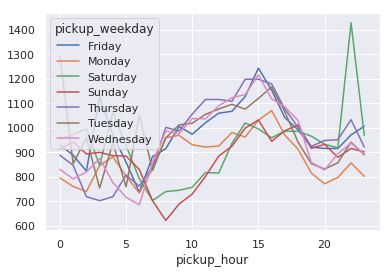

In [14]:
avg_trip_duration_per_weekday = df_train.groupby(['pickup_weekday', 'pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_weekday.unstack(level=0).plot(subplots=False)

In [88]:
avg_trip_duration_holiday = df_train.groupby(['holiday'])['trip_duration'].mean()
avg_trip_duration_holiday

holiday
False    962.197352
True     817.404609
Name: trip_duration, dtype: float64

#### Coordinates, distance and speed

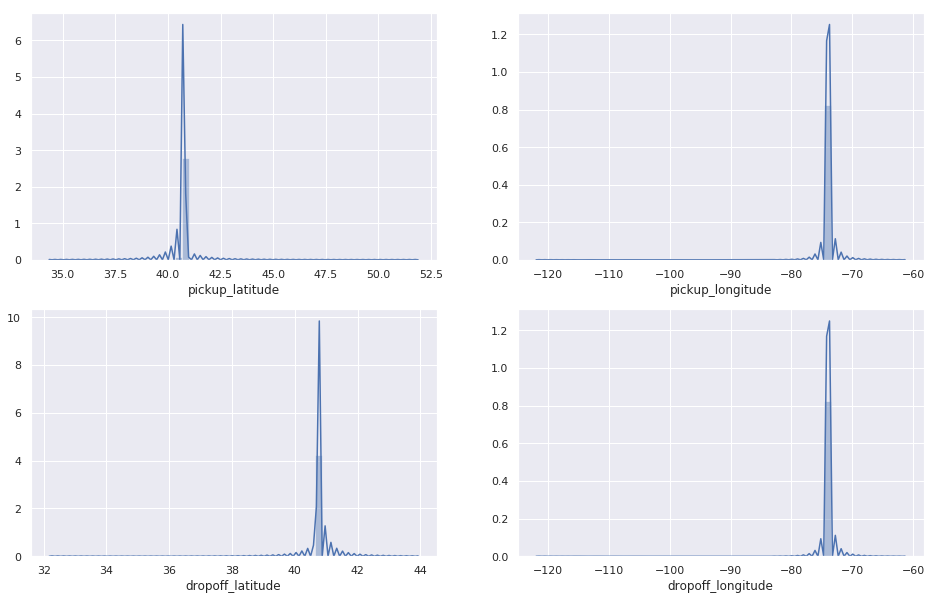

In [74]:
f, ax = plt.subplots(2,2,figsize=(16, 10), sharex=False, sharey = False)
sns.distplot(df_train['pickup_latitude'], axlabel = 'pickup_latitude',ax=ax[0,0])
sns.distplot(df_train['pickup_longitude'], axlabel = 'pickup_longitude', ax=ax[0,1])
sns.distplot(df_train['dropoff_latitude'], axlabel = 'dropoff_latitude', ax=ax[1, 0])
sns.distplot(df_train['dropoff_longitude'], axlabel = 'dropoff_longitude', ax=ax[1, 1])
plt.show()


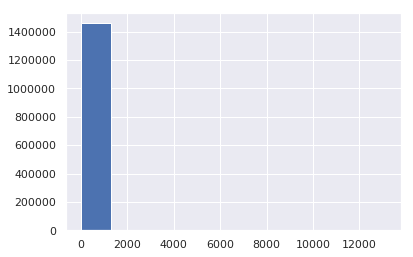

In [80]:
# df_train['avg_speed'].plot()
# df_train[(df_train['avg_speed']>1) & (df_train['avg_speed']<120 )]['avg_speed'].hist()
df_train['avg_speed'].hist()

#### Store and Forward

In [85]:
avg_trip_duration_per_store_flag = df_train.groupby(['store_and_fwd_flag'])['trip_duration'].mean()
# avg_trip_duration_per_weekday.unstack(level=0).plot(subplots=False)
avg_trip_duration_per_store_flag

store_and_fwd_flag
N     958.819706
Y    1080.763331
Name: trip_duration, dtype: float64

#### Number of Passangers

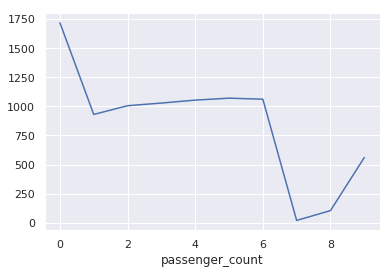

In [92]:
avg_trip_duration_per_passenger_count = df_train.groupby(['passenger_count'])['trip_duration'].mean()
avg_trip_duration_per_passenger_count.plot()

#### Trip Duration per Vendor Id

In [97]:
avg_trip_duration_per_vendor_id = df_train.groupby(['vendor_id'])['trip_duration'].mean()
avg_trip_duration_per_vendor_id

vendor_id
1     845.438244
2    1058.643164
Name: trip_duration, dtype: float64

In [ ]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
df_train['weekday_name'] = df_train['weekday_name'].astype(cat_type)